# Compare obs to SF and CC melt rates

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cmocean as cm

import matplotlib as matplotlib
plt.rcParams['hatch.color'] = 'w'
plt.rcParams['hatch.linewidth'] = 0.5
from scipy.optimize import fsolve
from gsw import CT_freezing

In [90]:
!pip install gsw


/Users/claireyung/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/var/folders/dq/psqyj9ns2m9b5kxdvtqz90bm0000gp/T/ipykernel_93901/2401909831.py:90: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(ustar_arr,sst_arr,melt_arr.T)


Text(0.5, 0, 'friction vel, m/s')

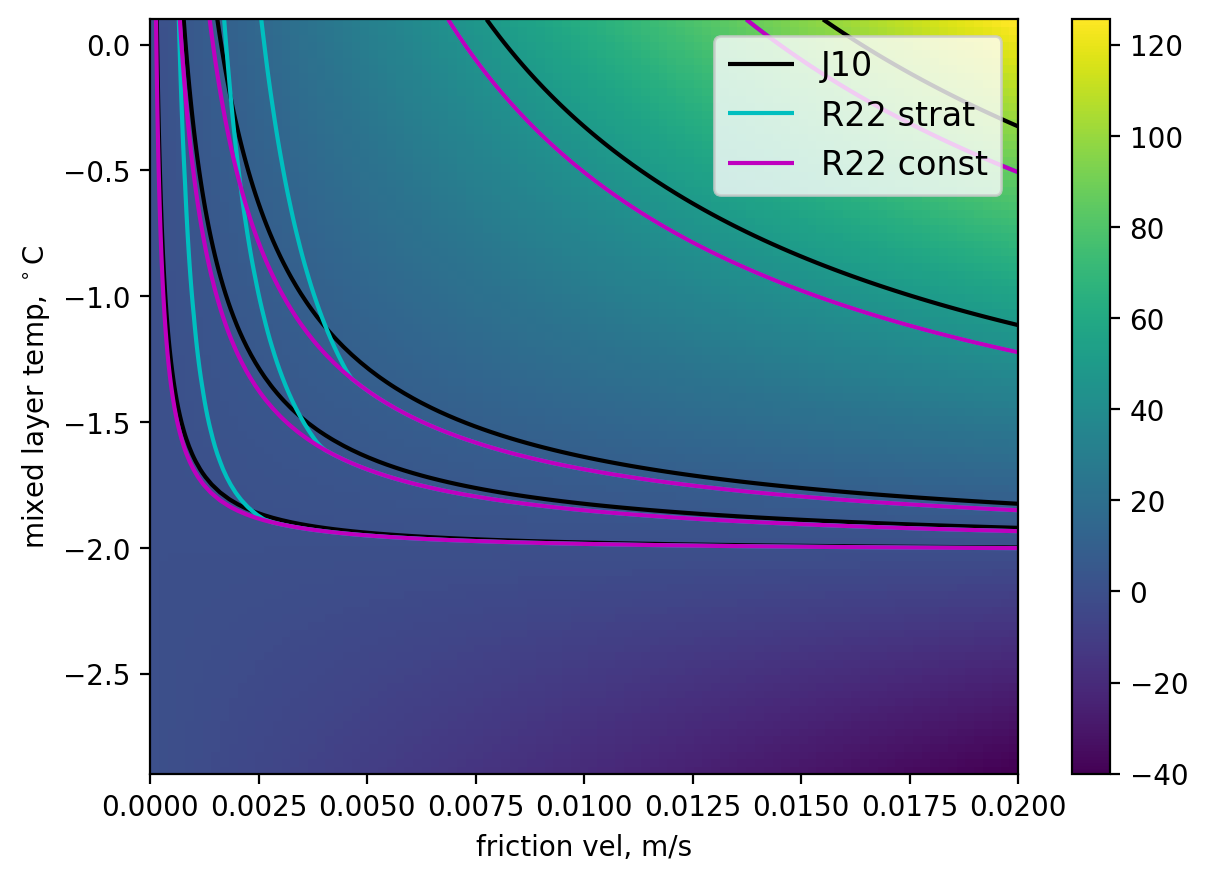

In [2]:
# python param
def solve_three_eqn_python_isomipcoeffs(ustar, depth, sst,
                    sss, J10_Gamma = True, Rosevear_Gamma = False, HJ99_Gamma = False, R22lim = False):
    
    R0 = 1030 #kg/m^3
    Cp = 3974 #J/K/kg
    lam_1 = -0.0573 #Ckg/g (salinity)
    lam_2 = -7.53e-4 #C/dbar (pressure)
    lam_3 = 0.0826 # offset
    L = 3.34e5 #J/kg
    Ri = 920 #kg/m^3
    g =9.81
    p = depth*R0*g #pascals p = rho*g*h for hydrostatic 
    p = p/1e4 #dbar
    I_VK = 1/0.41
    kv_molec = 2e-6
    dR0_dT = -0.0383569483 #[kg m-3 K-1] =alpha*R0
    dR0_dS = 0.805876093   #[kg m-3 PSU-1] =alpha*R0
    dB_dS = g/R0*dR0_dS
    dB_dT = g/R0*dR0_dT
    A =-9.89970135344883 #-9.29# -9.489
    B = 0.22260090020804837 #0.122 #0.155
    C = -7.3904118372660035 #-7.58 #-7.182
    D = 0.32220281249744703 #0.354 #0.290
    Lplus = 0
    def func(x):
        Tb,Sb,m = x
        return [Tb -lam_1*Sb-lam_2*p-lam_3,
                m - Cp/L*R0/Ri*Gam_T*ustar*(sst-Tb),
                m + R0/Ri*Gam_S*ustar*(Sb-sss)/Sb]
    
    if J10_Gamma == True:
        Gam_T = 0.011
        Gam_S = 3.1e-4

        root = fsolve(func, [-1,30,-1])
        
    elif R22lim ==True:
        Gam_T = 0.012
        Gam_S = 3.9e-4

        root = fsolve(func, [-1,30,-1])
        
    elif Rosevear_Gamma == True:
        tolerance = 1e-4
        Gam_T = 0.012
        Gam_S = 3.9e-4

        root = fsolve(func, [-1,30,-1])
        Tb,Sb,m = root
        #iterate to get convergent solution
        wB = dB_dS*(Sb-sss)*ustar*Gam_S + dB_dT*(Tb-sst)*ustar*Gam_T
        for i in np.arange(10):
            if (wB<0): #melting
                #print(i)
                Lplus = -ustar**4 * I_VK * 1.0/(kv_molec * wB)

                Gam_T = np.exp(C) * Lplus**(D) 
                Gam_S = np.exp(A) * Lplus**(B) 
                if Gam_T > 0.012:
                    Gam_T = 0.012
                if Gam_S > 3.9e-4:
                    Gam_S = 3.9e-4    
                root = fsolve(func, [-1,30,1])
                Tb,Sb,m = root
                wB = dB_dS*(Sb-sss)*ustar*Gam_S + dB_dT*(Tb-sst)*ustar*Gam_T
                Lplus_new = -ustar**4 * I_VK * 1.0/(kv_molec * wB)
                if np.abs(Lplus_new-Lplus) < tolerance:
                    break                    
            else:
                root = fsolve(func, [-1,30,1])
                break
            
    return root[0],root[1],root[2]*365*3600*24,Gam_T,Gam_S,Lplus #Tb,Sb,m in m/yr


## test

# solve_three_eqn_python(0.001, 200*9.8*1030/100, -1.5,34,J10_Gamma = True, Rosevear_Gamma = False)
fig,ax = plt.subplots(figsize = (7,5),dpi = 200)
ustar_arr = np.linspace(0,0.02,100)
sst_arr = np.linspace(-2.9,0.1,100)
melt_arr = np.zeros([100,100])
for m in np.arange(len(ustar_arr)):
    for n in np.arange(len(sst_arr)):
        #print(str(m)+', '+str(n))
        T,S,melt,Gam_T,Gam_S,Lplus = solve_three_eqn_python_isomipcoeffs(ustar_arr[m], depth = 200,sst = sst_arr[n],
                                                 sss = 34)
        melt_arr[m,n]=melt
plt.pcolormesh(ustar_arr,sst_arr,melt_arr.T)
plt.colorbar()

c1 = plt.contour(ustar_arr,sst_arr,melt_arr.T, levels = [1,5,10,50,100,200],colors = 'k')


melt_arr = np.zeros([100,100])
for m in np.arange(len(ustar_arr)):
    for n in np.arange(len(sst_arr)):
        #print(str(m)+', '+str(n))
        T,S,melt,Gam_T,Gam_S,Lplus = solve_three_eqn_python_isomipcoeffs(ustar_arr[m], depth = 200,sst = sst_arr[n],
                                                 sss = 34, J10_Gamma = False,Rosevear_Gamma = True)
        melt_arr[m,n]=melt
c2 = plt.contour(ustar_arr,sst_arr,melt_arr.T, levels = [1,5,10,50,100,200],colors = 'c')

melt_arr = np.zeros([100,100])
for m in np.arange(len(ustar_arr)):
    for n in np.arange(len(sst_arr)):
        #print(str(m)+', '+str(n))
        T,S,melt,Gam_T,Gam_S,Lplus = solve_three_eqn_python_isomipcoeffs(ustar_arr[m], depth = 200,sst = sst_arr[n],
                                                 sss = 34, J10_Gamma = False,R22lim = True,Rosevear_Gamma = False)
        melt_arr[m,n]=melt
c3 = plt.contour(ustar_arr,sst_arr,melt_arr.T, levels = [1,5,10,50,100,200],colors = 'm')
h3,l1 = c1.legend_elements()
h4,l1 = c2.legend_elements()
h5,l1 = c3.legend_elements()

#     plt.legend([h1[0],h4[0], h2[0],h5[0],h3[0]], ['KM15',r'MK18, $\theta = $'+str(theta), 'R22','R22lim','R22MK18 combo'], loc = 'upper right')

ax.legend([h3[0], h4[0],h5[0]], ['J10', 'R22 strat','R22 const'], loc = 'upper right', fontsize = 12)
ax.set_ylabel('mixed layer temp, $^\circ$C')
ax.set_xlabel('friction vel, m/s')


/Users/claireyung/opt/anaconda3/lib/python3.9/site-packages/gsw/_wrapped_ufuncs.py:742: RuntimeWarning: invalid value encountered in ct_freezing
  return _gsw_ufuncs.ct_freezing(SA, p, saturation_fraction)
/var/folders/dq/psqyj9ns2m9b5kxdvtqz90bm0000gp/T/ipykernel_93901/3495606551.py:90: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(ustar_arr,sst_arr,melt_arr.T)
/Users/claireyung/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The number of calls to function has reached maxfev = 800.
  warnings.warn(msg, RuntimeWarning)


Text(0.5, 0, 'friction vel, m/s')

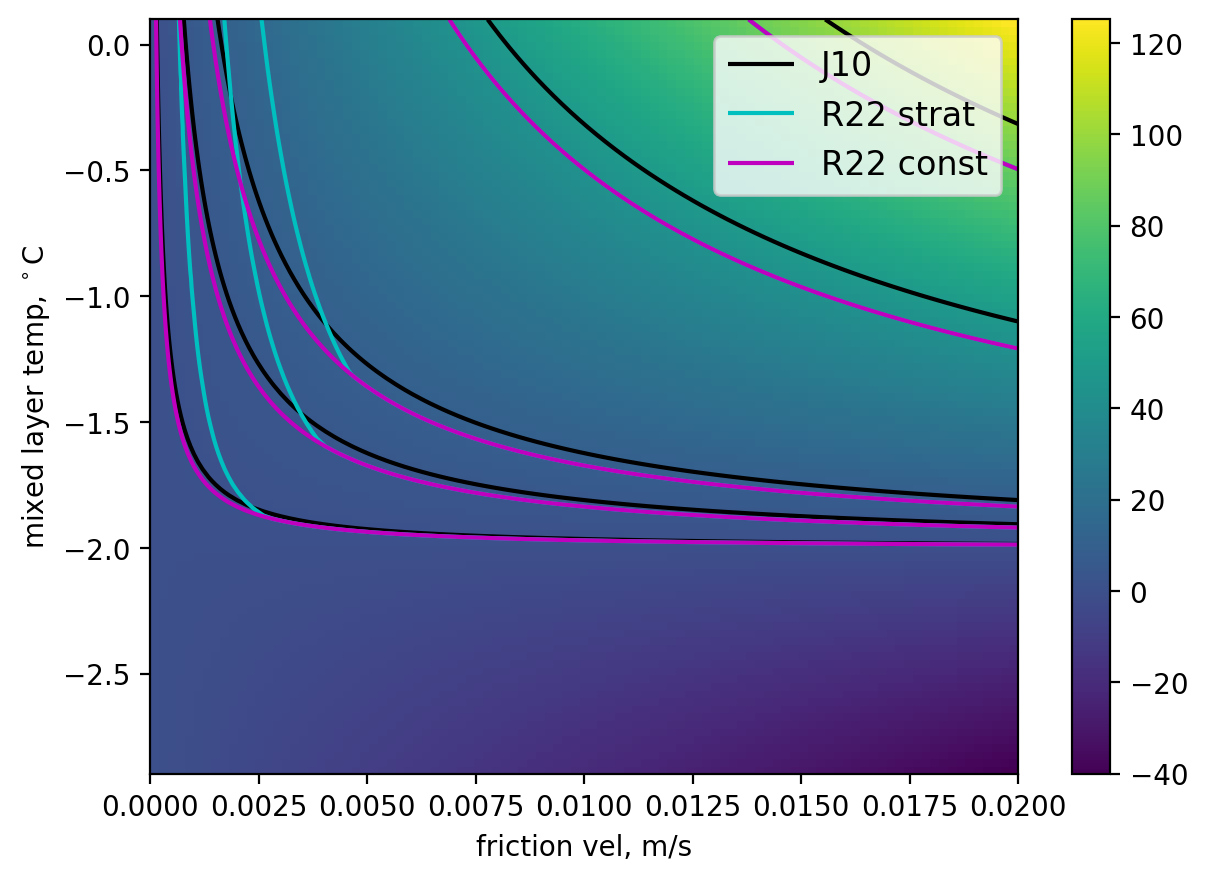

In [3]:
# python param
def solve_three_eqn_python_gswfreezing(ustar, depth, sst,
                    sss, J10_Gamma = True, Rosevear_Gamma = False, HJ99_Gamma = False, R22lim = False):
    
    R0 = 1030 #kg/m^3
    Cp = 3974 #J/K/kg
    lam_1 = -0.0573 #Ckg/g (salinity)
    lam_2 = -7.53e-4 #C/dbar (pressure)
    lam_3 = 0.0826 # offset
    L = 3.34e5 #J/kg
    Ri = 920 #kg/m^3
    g =9.81
    p = depth*R0*g #pascals p = rho*g*h for hydrostatic 
    p = p/1e4 #dbar
    I_VK = 1/0.41
    kv_molec = 2e-6
    dR0_dT = -0.0383569483 #[kg m-3 K-1] =alpha*R0
    dR0_dS = 0.805876093   #[kg m-3 PSU-1] =alpha*R0
    dB_dS = g/R0*dR0_dS
    dB_dT = g/R0*dR0_dT
    A =-9.89970135344883 #-9.29# -9.489
    B = 0.22260090020804837 #0.122 #0.155
    C = -7.3904118372660035 #-7.58 #-7.182
    D = 0.32220281249744703 #0.354 #0.290
    Lplus = 0
    def func(x):
        Tb,Sb,m = x
        return [Tb - CT_freezing(Sb,p,0),#-lam_1*Sb-lam_2*p-lam_3,
                m - Cp/L*R0/Ri*Gam_T*ustar*(sst-Tb),
                m + R0/Ri*Gam_S*ustar*(Sb-sss)/Sb]
    
    if J10_Gamma == True:
        Gam_T = 0.011
        Gam_S = 3.1e-4

        root = fsolve(func, [-1,30,-1])
        
    elif R22lim ==True:
        Gam_T = 0.012
        Gam_S = 3.9e-4

        root = fsolve(func, [-1,30,-1])
        
    elif Rosevear_Gamma == True:
        tolerance = 1e-4
        Gam_T = 0.012
        Gam_S = 3.9e-4

        root = fsolve(func, [-1,30,-1])
        Tb,Sb,m = root
        #iterate to get convergent solution
        wB = dB_dS*(Sb-sss)*ustar*Gam_S + dB_dT*(Tb-sst)*ustar*Gam_T
        for i in np.arange(10):
            if (wB<0): #melting
                #print(i)
                Lplus = -ustar**4 * I_VK * 1.0/(kv_molec * wB)

                Gam_T = np.exp(C) * Lplus**(D) 
                Gam_S = np.exp(A) * Lplus**(B) 
                if Gam_T > 0.012:
                    Gam_T = 0.012
                if Gam_S > 3.9e-4:
                    Gam_S = 3.9e-4    
                root = fsolve(func, [-1,30,1])
                Tb,Sb,m = root
                wB = dB_dS*(Sb-sss)*ustar*Gam_S + dB_dT*(Tb-sst)*ustar*Gam_T
                Lplus_new = -ustar**4 * I_VK * 1.0/(kv_molec * wB)
                if np.abs(Lplus_new-Lplus) < tolerance:
                    break                    
            else:
                root = fsolve(func, [-1,30,1])
                break
            
    return root[0],root[1],root[2]*365*3600*24,Gam_T,Gam_S,Lplus #Tb,Sb,m in m/yr


## test

# solve_three_eqn_python(0.001, 200*9.8*1030/100, -1.5,34,J10_Gamma = True, Rosevear_Gamma = False)
fig,ax = plt.subplots(figsize = (7,5),dpi = 200)
ustar_arr = np.linspace(0,0.02,100)
sst_arr = np.linspace(-2.9,0.1,100)
melt_arr = np.zeros([100,100])
for m in np.arange(len(ustar_arr)):
    for n in np.arange(len(sst_arr)):
        #print(str(m)+', '+str(n))
        T,S,melt,Gam_T,Gam_S,Lplus = solve_three_eqn_python_gswfreezing(ustar_arr[m], depth = 200,sst = sst_arr[n],
                                                 sss = 34)
        melt_arr[m,n]=melt
plt.pcolormesh(ustar_arr,sst_arr,melt_arr.T)
plt.colorbar()

c1 = plt.contour(ustar_arr,sst_arr,melt_arr.T, levels = [1,5,10,50,100,200],colors = 'k')


melt_arr = np.zeros([100,100])
for m in np.arange(len(ustar_arr)):
    for n in np.arange(len(sst_arr)):
        #print(str(m)+', '+str(n))
        T,S,melt,Gam_T,Gam_S,Lplus = solve_three_eqn_python_gswfreezing(ustar_arr[m], depth = 200,sst = sst_arr[n],
                                                 sss = 34, J10_Gamma = False,Rosevear_Gamma = True)
        melt_arr[m,n]=melt
c2 = plt.contour(ustar_arr,sst_arr,melt_arr.T, levels = [1,5,10,50,100,200],colors = 'c')

melt_arr = np.zeros([100,100])
for m in np.arange(len(ustar_arr)):
    for n in np.arange(len(sst_arr)):
        #print(str(m)+', '+str(n))
        T,S,melt,Gam_T,Gam_S,Lplus = solve_three_eqn_python_gswfreezing(ustar_arr[m], depth = 200,sst = sst_arr[n],
                                                 sss = 34, J10_Gamma = False,R22lim = True,Rosevear_Gamma = False)
        melt_arr[m,n]=melt
c3 = plt.contour(ustar_arr,sst_arr,melt_arr.T, levels = [1,5,10,50,100,200],colors = 'm')
h3,l1 = c1.legend_elements()
h4,l1 = c2.legend_elements()
h5,l1 = c3.legend_elements()

#     plt.legend([h1[0],h4[0], h2[0],h5[0],h3[0]], ['KM15',r'MK18, $\theta = $'+str(theta), 'R22','R22lim','R22MK18 combo'], loc = 'upper right')

ax.legend([h3[0], h4[0],h5[0]], ['J10', 'R22 strat','R22 const'], loc = 'upper right', fontsize = 12)
ax.set_ylabel('mixed layer temp, $^\circ$C')
ax.set_xlabel('friction vel, m/s')


In [4]:
def plot_R22Lplus(ax):
    verbose = False
    sss = 34.5
    ustar_arr = np.linspace(0,0.019,400)
    sst_arr = np.concatenate([np.linspace(-2.26,-2.16,201)[:-1],np.linspace(-2.16,-2.27075+5,200)])
    melt_arr_R22 = np.zeros([400,400])
    Lplus_arr = np.zeros([400,400])
    dTFr_dS = -0.0573 #degC psu-1
    dTFr_dp = -7.53E-08 #dTFr_dp = 0.0 #degC Pa-1
    Cp = 3991.86795711963 #J kg-1 K-1
    Lat_fusion = 334000 #J/kg
    TFr_0_0 = 0.0826 #degC
    #p_int = 500*1e4
    depth = 500
    def Tfreeze(S,p):
        lam_1 = -0.0573 #Ckg/g (salinity)
        lam_2 = -7.53e-4 #C/dbar (pressure)
        lam_3 = 0.0826 # offset
        return lam_3+lam_1*S+lam_2*p

    tfreeze = Tfreeze(sss,depth)#(TFr_0_0 + dTFr_dS*sss) + dTFr_dp*p_int
    tfreeze


    for m in np.arange(len(ustar_arr)):
        for n in np.arange(len(sst_arr)):
            #print(str(m)+', '+str(n))
#             salts, melts, Lplusses,exch_vel_t = solve_three_eqn_mom6(ustar_arr[m], #Rhoml = 1027.6458676164675, 
#                                                      p_int = p_int,sst = sst_arr[n],
#                                                      sss = sss, Rosevear_Gamma = True,
#                                                      const_Gamma = False, old_Gamma = False, J10_Gamma = False, 
#                                                      KM15 = False , ShearConvParam = False)
            
#             melt_arr_R22[m,n]=melts
#             Lplus_arr[m,n] = Lplusses
            T,S,melt,Gam_T,Gam_S,Lplus = solve_three_eqn_python_isomipcoeffs(ustar_arr[m], depth = 500,
                                                                                   sst = sst_arr[n],
                                                 sss = sss, J10_Gamma = False,Rosevear_Gamma = True)
            melt_arr_R22[m,n]=melt
            Lplus_arr[m,n] = Lplus

    Freezing_point = tfreeze 
    #fig,ax = plt.subplots(dpi = 200)

    #C = ax.pcolormesh(ustar_arr,sst_arr-tfreeze,Lplus_arr.T, cmap = cm.cm.rain_r,norm=matplotlib.colors.LogNorm(),alpha = 0.5)
    #plt.colorbar(C,ax = ax,label = 'Viscous Obukhov Scale, $L^+$ \n derived from R22 parameterisation')
    CS5 = ax.contour(ustar_arr,sst_arr-tfreeze,Lplus_arr.T, levels = np.array([10,1e2,1e3,1e4,1e5,1e6]), linewidths = [1,1,1,3,1,1],colors = 'k', linestyles = '-')
    #ax.set_yscale('log')
    #ax.set_xscale('log')
#     plt.clabel(CS5, CS5.levels, inline=True, inline_spacing = 20, fontsize=10, fmt = {1e1:'$10^1$',
#                                                                 1e2:'$10^2$',
#                                                                 1e3:'$10^3$',
#                                                                 1e4:'$10^4$',
#                                                                 1e5:'$10^5$',
#                                                                 1e6:'$10^6$'},
#               )
    
    h6,l1 = CS5.legend_elements()
    #ax.legend([ h6[0]], ['$L^+$',], loc = 'upper right')


    ax.set_xlabel('Friction Velocity, $u_*$ (m/s)')
    ax.set_ylabel('Thermal Driving, $T^*$ ($^\circ$C)')
    
    return h6
    #ax.set_title('Melt Rate for SSS = '+str(sss))
    #ax.set_xticks([0,0.005,0.01,0.015,0.02]);
    #plt.show()

In [5]:
def plot_R22Lplus_with_regimes(ax):
    verbose = False
    sss = 34.5
    ustar_arr = np.linspace(0,0.019,400)
    sst_arr = np.concatenate([np.linspace(-2.26,-2.16,201)[:-1],np.linspace(-2.16,-2.27075+5,200)])
    melt_arr_R22 = np.zeros([400,400])
    Lplus_arr = np.zeros([400,400])
    dTFr_dS = -0.0573 #degC psu-1
    dTFr_dp = -7.53E-08 #dTFr_dp = 0.0 #degC Pa-1
    Cp = 3991.86795711963 #J kg-1 K-1
    Lat_fusion = 334000 #J/kg
    TFr_0_0 = 0.0826 #degC
    #p_int = 500*1e4
    depth = 500
    def Tfreeze(S,p):
        lam_1 = -0.0573 #Ckg/g (salinity)
        lam_2 = -7.53e-4 #C/dbar (pressure)
        lam_3 = 0.0826 # offset
        return lam_3+lam_1*S+lam_2*p

    tfreeze = Tfreeze(sss,depth)#(TFr_0_0 + dTFr_dS*sss) + dTFr_dp*p_int
    tfreeze


    for m in np.arange(len(ustar_arr)):
        for n in np.arange(len(sst_arr)):
            #print(str(m)+', '+str(n))
#             salts, melts, Lplusses,exch_vel_t = solve_three_eqn_mom6(ustar_arr[m], #Rhoml = 1027.6458676164675, 
#                                                      p_int = p_int,sst = sst_arr[n],
#                                                      sss = sss, Rosevear_Gamma = True,
#                                                      const_Gamma = False, old_Gamma = False, J10_Gamma = False, 
#                                                      KM15 = False , ShearConvParam = False)
            
#             melt_arr_R22[m,n]=melts
#             Lplus_arr[m,n] = Lplusses
            T,S,melt,Gam_T,Gam_S,Lplus = solve_three_eqn_python_isomipcoeffs(ustar_arr[m], depth = 500,
                                                                                   sst = sst_arr[n],
                                                 sss = sss, J10_Gamma = False,Rosevear_Gamma = True)
            melt_arr_R22[m,n]=melt
            Lplus_arr[m,n] = Lplus

    Freezing_point = tfreeze 
    #fig,ax = plt.subplots(dpi = 200)

    #C = ax.pcolormesh(ustar_arr,sst_arr-tfreeze,Lplus_arr.T, cmap = cm.cm.rain_r,norm=matplotlib.colors.LogNorm(),alpha = 0.5)
    #plt.colorbar(C,ax = ax,label = 'Viscous Obukhov Scale, $L^+$ \n derived from R22 parameterisation')

    #CS5 = ax.contour(ustar_arr,sst_arr-tfreeze,Lplus_arr.T, levels = np.array([10,1e2,1e3,1e4,1e5,1e6]), linewidths = [1,1,1,3,1,1],colors = 'k', linestyles = '-')
    CS6 = ax.contourf(ustar_arr,sst_arr-tfreeze,Lplus_arr.T, levels = np.array([0,2500,1e4]),
                      cmap = cm.cm.thermal,extend = 'both',alpha = 0.15,zorder=10)
    return CS6

    #ax.set_yscale('log')
    #ax.set_xscale('log')
#     plt.clabel(CS5, CS5.levels, inline=True, inline_spacing = 20, fontsize=10, fmt = {1e1:'$10^1$',
#                                                                 1e2:'$10^2$',
#                                                                 1e3:'$10^3$',
#                                                                 1e4:'$10^4$',
#                                                                 1e5:'$10^5$',
#                                                                 1e6:'$10^6$'},
#               )
    
    #h6,l1 = CS5.legend_elements()
    #ax.legend([ h6[0]], ['$L^+$',], loc = 'upper right')


    #ax.set_xlabel('Friction Velocity, $u_*$ (m/s)')
    #ax.set_ylabel('Thermal Driving, $T^*$ ($^\circ$C)')
    #return CS6
    #ax.set_title('Melt Rate for SSS = '+str(sss))
    #ax.set_xticks([0,0.005,0.01,0.015,0.02]);
    #plt.show()

In [6]:
def Tfreeze(S,p):
    lam_1 = -0.069 #Ckg/g (salinity)
    lam_2 = -7.6e-4 #C/dbar (pressure)
    lam_3 = 0.0826 # offset
    return lam_3+lam_1*S+lam_2*p
print(Tfreeze(34.5,500))
def Tfreeze(S,p):
    lam_1 = -0.0573 #Ckg/g (salinity)
    lam_2 = -7.53e-4 #C/dbar (pressure)
    lam_3 = 0.0826 # offset
    return lam_3+lam_1*S+lam_2*p

print(Tfreeze(34.5,500))

-2.6779
-2.27075


In [7]:
CT_freezing(34.5,500,0)

-2.264985963256962

In [8]:
def plot_R22Lplus_python_gswfreezing(ax):
    verbose = False
    sss = 34.5
    ustar_arr = np.linspace(0,0.02,200)
    sst_arr = np.linspace(-2.2,1.5,200)
    melt_arr_R22 = np.zeros([200,200])
    Lplus_arr = np.zeros([200,200])
    dTFr_dS = -0.0573 #degC psu-1
    dTFr_dp = -7.53E-08 #dTFr_dp = 0.0 #degC Pa-1
    Cp = 3991.86795711963 #J kg-1 K-1
    Lat_fusion = 334000 #J/kg
    TFr_0_0 = 0.0826 #degC
    p_int = 500

    tfreeze = CT_freezing(sss,p_int,0) #(TFr_0_0 + dTFr_dS*sss) + dTFr_dp*p_int
    tfreeze


    for m in np.arange(len(ustar_arr)):
        for n in np.arange(len(sst_arr)):
            #print(str(m)+', '+str(n))
            T,S,melt,Gam_T,Gam_S,Lplus = solve_three_eqn_python_gswfreezing(ustar_arr[m], depth = 500,
                                                                                   sst = sst_arr[n],
                                                 sss = sss, J10_Gamma = False,Rosevear_Gamma = True)
            melt_arr_R22[m,n]=melt
            Lplus_arr[m,n] = Lplus

    Freezing_point = tfreeze 
    #fig,ax = plt.subplots(dpi = 200)

    #C = ax.pcolormesh(ustar_arr,sst_arr-tfreeze,Lplus_arr.T, cmap = cm.cm.rain_r,norm=matplotlib.colors.LogNorm(),alpha = 0.5)
    #plt.colorbar(C,ax = ax,label = 'Viscous Obukhov Scale, $L^+$ \n derived from R22 parameterisation')
    CS5 = ax.contour(ustar_arr,sst_arr-tfreeze,Lplus_arr.T, levels = np.array([10,1e2,1e3,1e4,1e5,1e6]), linewidths = [1,1,1,3,1,1],colors = 'k', linestyles = '-')
#     plt.clabel(CS5, CS5.levels, inline=True, fontsize=10, fmt = {1e1:'$10^1$',
#                                                                 1e2:'$10^2$',
#                                                                 1e3:'$10^3$',
#                                                                 1e4:'$10^4$',
#                                                                 1e5:'$10^5$',
#                                                                 1e6:'$10^6$'})
    
    h6,l1 = CS5.legend_elements()
    ax.legend([ h6[0]], ['$L^+$',], loc = 'upper right')


    ax.set_xlabel('Friction Velocity, $u_*$ (m/s)')
    ax.set_ylabel('Thermal Driving, $T^*$ ($^\circ$C)')
    #ax.set_title('Melt Rate for SSS = '+str(sss))
    ax.set_xticks([0,0.005,0.01,0.015,0.02]);
    #plt.show()

In [9]:
import cartopy  # Map projections libary
import cartopy.crs as ccrs  # Projections list

/Users/claireyung/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Thermal Driving 0.19322600000000012
Madi TD 0.19
Amery R22 const coeff mr =  1.1730944218633752
Amery R22 strat mr =  0.8722706519432604 impliedLplus 3516.7088536075235
Thermal Driving 0.03192299999999948
Madi TD 0.05
FRIS R22 const coeff mr =  0.32936405693747073
FRIS R22 strat mr =  0.3293640569374701 impliedLplus 45626.427963687005
Thermal Driving 0.04545399999999944
Madi TD 0.05
Larsen C R22 const coeff mr =  0.49154074973652784
Larsen C R22 strat mr =  0.49154074973454676 impliedLplus 56725.441441479226
Thermal Driving 2.4398269999999993
Madi TD 2.3
George VI R22 const coeff mr =  16.992023549715196
George VI R22 strat mr =  7.397324841662433 impliedLplus 634.0885689417006
Thermal Driving 0.12918699999999994
Madi TD 0.12
Ross W R22 const coeff mr =  2.4220041630320446
Ross W R22 strat mr =  2.4220041630320805 impliedLplus 119578.09642430083
Thermal Driving 0.375227
Madi TD 0.38
Ross S R22 const coeff mr =  5.709456458628691
Ross S R22 strat mr =  5.709456458628692 impliedLplus 221

/Users/claireyung/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


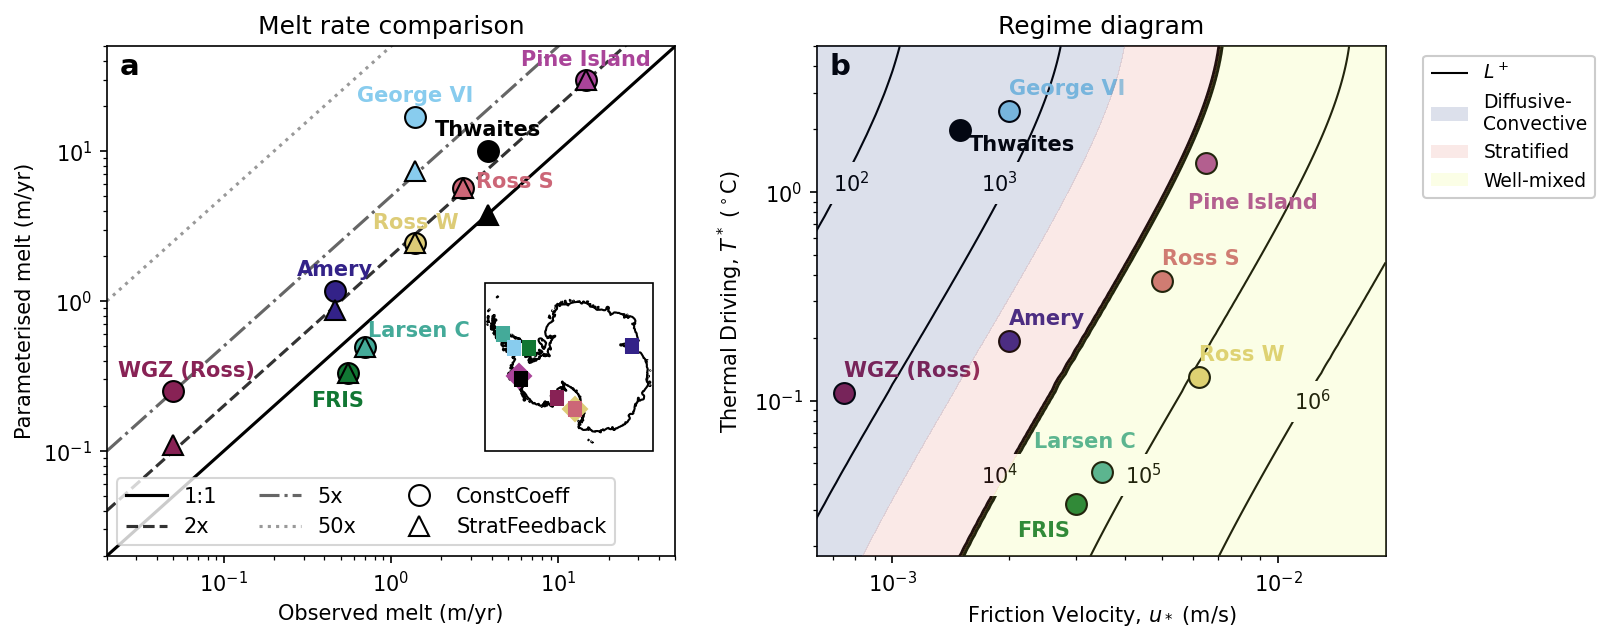

In [16]:
Obs = {'Amery':{'T_m':-2.1 , ## average of blue line, Fig. 4a (visual inspection, Thermal driving of 0.19K given)
              'S_m':34.59, ## average of blue line, Fig. 4b (visual inspection)
              'depth':523, #given
              'u':4e-2, #given, Table 4
              'obsm':0.46, #given, Table 4
              'madiJ10':1.9,
              'madiTstar':0.19,
              'color':'#332288',
             'lat':-70.25,'lon':71.5},
       'FRIS':{
           'T_m':-2.39 , ## average of Fig 4 (visual inspection)
           'S_m':34.51, #given, assumed constant in their calcs
           'depth':700, #ice is 816m thick, so pressure = 0.9*816 \appox 700
           'u':6e-2, #not sure where I got this - hard to visually inspect plot, and its only for one day. Could be between 5-15cm/s from one day snapshot. Definitely needs asterisk
           'obsm':0.554, 'madiJ10':0.553,
              'madiTstar':0.05, #approximate
           'color':'#117733',
              'lat':-77,'lon':-65},
       'Larsen C':{'T_m':-2.08 , #given
               'S_m':34.54, #given to be assumed
               'depth':304, #given
               'u':7e-2, #taken from R22, which was calculated from figure
               'obsm':0.7, 'madiJ10':0.69,
               'madiTstar':0.05,
               'color':'#44AA99',
              'lat':-68.25,'lon':-63.3}, 
       'George VI':{'T_m':0.3 , #given 20m below ice
               'S_m':34.62,  #given 20m below ice
               'depth':317,  #given ice thickness of 380 (middleton 2022)-> pressure of 380*0.9=340
               'u':4e-2, ## Middleton 2022 gives u of 4cm/s and ustar around 0.1cm/s (visual inspection)
               'obsm':1.4, 'madiJ10':71,
               'madiTstar':2.3, 
               'color':'#88CCEE',
              'lat':-72.8,'lon':-70.8},
       'Ross W':{'T_m':-1.9375 , #average of winter results, table 3.2
                'S_m':34.5, #winter mean of Fig 2.5 (visual inspection)
                'depth':229, #pressure of TS logger #1
                'u':12.5e-2, #average of summer results, table 3.2
                'obsm':1.4, #average of summer results, table 3.2
                'madiJ10':3.8,
                'madiTstar':0.12, 
                'color':'#DDCC77',
               'lat':-77.3,'lon':171.5},
       'Ross S':{'T_m':-1.68 ,  #average of summer results, table 3.2
                'S_m':34.3, #summer mean of Fig 2.5 (visual inspection)
                'depth':229, #pressure of TS logger #1
                'u':10e-2, #average of summer results, table 3.2
                'obsm':2.7, #average of summer results, table 3.2
                'madiJ10':10,
                'madiTstar':0.38, 
                'color':'#CC6677',
               'lat':-77.3,'lon':171.5}, #S??
       'Pine Island':{'T_m':-0.82 , # back calculated from 1.4 degrees departure of freezing and my freezing EOS
               'S_m':33.85, #given
               'depth':460, #given
               'u':13e-2, #average of given range
               'obsm':14.6, 'madiJ10':50,
               'madiTstar':1.39, #plot shows departure from freezing of 1.4
               'color':'#AA4499',
              'lat':-75,'lon':-101},
       'WGZ (Ross)':{'T_m': -2.3, #average of UL temp (tavble 2)
                   'S_m':34.74, #average of UL salinity Ttable 2)
                   'depth':665, # (Fig 3)
                   'u':1.5e-2, #given
                   'obsm':0.05, 'madiJ10':0.24, 
                   'madiTstar':0.1, #given tstar of 0.1
                   'color':'#882255',
                  'lat':-80,'lon':-160},
       'Thwaites': #from inspection of Davis 2022 figures
       {'T_m': -0.3, #visual inspection of Fig 3a
        'S_m':34.38, #visual inspection of Fig 3a
        'depth':515, #Fig 2
        'u':3e-2, #visual inspection of Extended Data Fig 4a
        'obsm':3.8, #average of given range
        'madiJ10':15,#from Davis23 not R22
        'madiTstar':2, #from Davis23 not R22
        'color':'k',
       'lat':-75.2,'lon':-104.8},
       
       }

fig, axes = plt.subplots( figsize = (11,4.5),dpi = 150, ncols = 2)

h6 = plot_R22Lplus(axes[1])

#for name in Obs:

axes[0].plot([0.02,100],[0.02,100],'-k', label = '1:1')
axes[0].plot([0.02,100],[0.04,200],'--k', label = '2x',alpha = 0.8)
axes[0].plot([0.02,100],[0.1,500],'-.k', label = '5x',alpha = 0.6)
axes[0].plot([0.02,100],[0.02*50,100*50],':k', label = '50x',alpha = 0.4)

ax_inset = plt.axes([0.28,0.28,0.25,0.25],projection=ccrs.SouthPolarStereo())
ax_inset.set_extent([-180, 180, -90, -65], ccrs.PlateCarree())
ax_inset.coastlines()
#ax_inset.axis('off')


for k, d in Obs.items():

    ustar_J10 = d['u']*np.sqrt(0.0097)
    ustar_isomip = d['u']*np.sqrt(0.0025)
    #if k == 'G VI':
    #    ustar_isomip = 0.1e-2 #m/s from Middleton et al. 2022
    ThermalDriving = d['T_m'] - Tfreeze(d['S_m'],d['depth'])
    #print(d['T_m'])
    #print(Tfreeze(d['S_m'],d['depth']))
    print('Thermal Driving',ThermalDriving)
    print('Madi TD',d['madiTstar'])
    
    T,S,meltR22lim,GT,GS,Lplus = solve_three_eqn_python_isomipcoeffs(ustar_isomip, d['depth'], 
                                                            d['T_m'], d['S_m'],
                                                            J10_Gamma = False, Rosevear_Gamma = False,R22lim = True)
    axes[0].plot( d['obsm'],meltR22lim, 'o', color = d['color'], markersize = 10, mec = 'k')
    print(k,'R22 const coeff mr = ',meltR22lim)
    T,S,meltR22strat,GT,GS,Lplus = solve_three_eqn_python_isomipcoeffs(ustar_isomip, d['depth'], 
                                                            d['T_m'], d['S_m'],
                                                            J10_Gamma = False, Rosevear_Gamma = True)
    axes[0].plot( d['obsm'],meltR22strat, '^',color = d['color'], markersize = 10, mec = 'k')
    print(k,'R22 strat mr = ',meltR22strat, 'impliedLplus',Lplus)
    #cs = axes[1].plot( ustar_isomip,ThermalDriving, label = k,color='black',marker='o', markersize = 10,markerfacecolor = d['color'])
    cs = axes[1].plot( ustar_isomip,ThermalDriving, 'o',color = d['color'],markersize = 10, mec = 'k')
    if (k=='FRIS'):
        axes[0].text(d['obsm']*0.6,meltR22lim*0.6,k,ha = 'left',color = d['color'],fontweight = 'bold')  
    elif (k == 'Larsen C'):
        axes[0].text(d['obsm']*2.1,meltR22lim*1.5,k,ha = 'center', va = 'top',color = d['color'],fontweight = 'bold')  
    elif (k == 'Ross S'):
        axes[0].text(d['obsm']*1.2,meltR22lim*1,k,ha = 'left',color = d['color'],fontweight = 'bold')  
    elif (k == 'WGZ (Ross)'):
        axes[0].text(d['obsm']*1.2,meltR22lim*1.25,k,ha = 'center',color = d['color'],fontweight = 'bold')
    else:
        axes[0].text(d['obsm'],meltR22lim*1.25,k,ha = 'center',color = d['color'],fontweight = 'bold')
#     if (k=='FRIS' or k=='RIS S'):
#         axes[1].text(ustar_isomip*1.3,ThermalDriving*0.8,k,ha = 'center',color = d['color'],fontweight = 'bold')  
#    if (k =='WGZ(RIS)'):
#        axes[1].text(ustar_isomip*1.3,ThermalDriving*1.15,k,ha = 'center',color = d['color'],fontweight = 'bold')        
    if (k == 'Larsen C'):
        axes[1].text(ustar_isomip*0.9,ThermalDriving*1.3,k,ha = 'center',color = d['color'],fontweight = 'bold')        
    elif (k == 'Thwaites'):
        axes[1].text(ustar_isomip*1.05,ThermalDriving*0.8,k,ha = 'left',color = d['color'],fontweight = 'bold')        
    elif (k == 'Pine Island'):
        axes[1].text(ustar_isomip*0.9,ThermalDriving*0.6,k,ha = 'left',color = d['color'],fontweight = 'bold')        
    elif (k == 'FRIS'):
        axes[1].text(ustar_isomip*0.7,ThermalDriving*0.7,k,ha = 'left',color = d['color'],fontweight = 'bold')        
    else:
        axes[1].text(ustar_isomip*1.0,ThermalDriving*1.2,k,ha = 'left',color = d['color'],fontweight = 'bold')
    if (k == 'Pine Island'):
        ax_inset.plot(d['lon'],d['lat'],'D',color = d['color'],markersize = 8,transform=ccrs.PlateCarree())
    elif (k == 'Ross W'):
        ax_inset.plot(d['lon'],d['lat'],'D',color = d['color'],markersize = 8,transform=ccrs.PlateCarree())        
    else:
        ax_inset.plot(d['lon'],d['lat'],'s',color = d['color'],markersize = 6,transform=ccrs.PlateCarree())
    
axes[0].plot( 0.0001,0.0001, 'o', color = 'w', mec = 'k',markersize = 10, label = 'ConstCoeff')
axes[0].plot( 0.0001,0.0001, '^',color = 'w', mec = 'k',markersize = 10, label = 'StratFeedback')

axes[0].legend(ncol = 3,loc = 'lower left')#,bbox_to_anchor = (0.02,0.98))

axes[0].set_xlabel('Observed melt (m/yr)')
axes[0].set_ylabel('Parameterised melt (m/yr)')
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_xlim(0.02,50)
axes[0].set_ylim(0.02,50)
axes[0].set_title('Melt rate comparison');
axes[1].set_yscale('log')
axes[1].set_xscale('log')
axes[1].set_ylim(1.8e-2,5)
axes[1].set_title('Regime diagram')
axes[0].text(0.04,0.96,'a',horizontalalignment='center', fontweight='bold',
     verticalalignment='center',transform=axes[0].transAxes, fontsize = 14)
axes[1].text(0.04,0.96,'b',horizontalalignment='center', fontweight='bold',
     verticalalignment='center',transform=axes[1].transAxes, fontsize = 14)

cs =cm.cm.thermal(np.array([75,100,150,250]))
purple = (cs[0,0],cs[0,1],cs[0,2])
red = (cs[2,0],cs[2,1],cs[2,2])
yellow = (cs[3,0],cs[3,1],cs[3,2])

t = axes[1].text(7e-4,1,r'$10^2$',fontsize = 10)
t.set_bbox(dict(facecolor='white', alpha=1, linewidth=0))
t = axes[1].text(1.7e-3,1,r'$10^3$',fontsize = 10)
t.set_bbox(dict(facecolor='white', alpha=1, linewidth=0))
t = axes[1].text(1.7e-3,4e-2,r'$10^4$',fontsize = 10)
t.set_bbox(dict(facecolor='white', alpha=1, linewidth=0))
t = axes[1].text(4e-3,4e-2,r'$10^5$',fontsize = 10)
t.set_bbox(dict(facecolor='white', alpha=1, linewidth=0))
t = axes[1].text(1.1e-2,9e-2,r'$10^6$',fontsize = 10)
t.set_bbox(dict(facecolor='white', alpha=1, linewidth=0))

# axes[1].text(6.8e-4,2e-1,'Diffusive-\nConvective',ha = 'left',fontsize = 8,style='italic',)
# axes[1].text(0.9e-3,2e-2,'Stratified',ha = 'left',fontsize = 8,style='italic',)
# axes[1].text(0.85e-2,2e-2,'Well-mixed',ha = 'left',fontsize = 8,style='italic',)

CS6 = plot_R22Lplus_with_regimes(axes[1])
# cax = plt.axes([0.93,0.15,0.01,0.7])
# cbar = plt.colorbar(CS6, cax = cax)
# cbar.set_label('', rotation=270, labelpad=15)
# cbar.set_ticks([0,2500,1e4,1e6])
# cbar.set_ticklabels(['Diffusive-\nConvective', 'Stratified', 'Well-mixed'])
proxy = [plt.Rectangle((0,0),1,1,fc = pc.get_facecolor()[0]) 
    for pc in CS6.collections]
axes[1].legend([h6[0]]+proxy[1:], ["$L^+$","Diffusive-\nConvective", "Stratified", "Well-mixed"], 
               loc = 'upper left', bbox_to_anchor = (1.05,1),
              facecolor='white', fontsize = 9, framealpha=1)
# axes[1].legend([h6[0]], ["$L^+$"], loc = 'lower right',
#               facecolor='white', framealpha=1), 


fig.subplots_adjust(wspace = 0.25)

In [11]:
proxy[0]#.alpha

In [ ]:
#same as above, but with GSW

fig, axes = plt.subplots( figsize = (11,4.5),dpi = 150, ncols = 2)
plot_R22Lplus_python_gswfreezing(axes[1])
#for name in Obs:

axes[0].plot([0.02,100],[0.02,100],'-k', label = '1:1')
axes[0].plot([0.02,100],[0.04,200],'--k', label = '2x',alpha = 0.8)
axes[0].plot([0.02,100],[0.1,500],'-.k', label = '5x',alpha = 0.6)
axes[0].plot([0.02,100],[0.02*50,100*50],':k', label = '50x',alpha = 0.4)

ax_inset = plt.axes([0.05,0.55,0.3,0.3],projection=ccrs.SouthPolarStereo())
ax_inset.set_extent([-180, 180, -90, -65], ccrs.PlateCarree())
ax_inset.coastlines()
ax_inset.axis('off')


for k, d in Obs.items():

    ustar_J10 = d['u']*np.sqrt(0.0097)
    ustar_isomip = d['u']*np.sqrt(0.0025)
    if k == 'G VI':
        ustar_isomip = 0.1e-2 #m/s from Middleton et al. 2022
    ThermalDriving = d['T_m'] - CT_freezing(d['S_m'],d['depth'],0)#Tfreeze(d['S_m'],d['depth'])
    print(d['T_m'])
    print(CT_freezing(d['S_m'],d['depth'],0))
    print('Thermal Driving',ThermalDriving)
    
    T,S,meltR22lim,GT,GS,Lplus = solve_three_eqn_python_gswfreezing(ustar_isomip, d['depth'], 
                                                            d['T_m'], d['S_m'],
                                                            J10_Gamma = False, Rosevear_Gamma = False,R22lim = True)
    axes[0].plot( d['obsm'],meltR22lim, 'o', color = d['color'], markersize = 10, mec = 'k')
    print(k,'R22 const coeff mr = ',meltR22lim)
    T,S,meltR22strat,GT,GS,Lplus = solve_three_eqn_python_gswfreezing(ustar_isomip, d['depth'], 
                                                            d['T_m'], d['S_m'],
                                                            J10_Gamma = False, Rosevear_Gamma = True)
    axes[0].plot( d['obsm'],meltR22strat, '^',color = d['color'], markersize = 10, mec = 'k')
    print(k,'R22 strat mr = ',meltR22strat, 'impliedLplus',Lplus)
    #cs = axes[1].plot( ustar_isomip,ThermalDriving, label = k,color='black',marker='o', markersize = 10,markerfacecolor = d['color'])
    cs = axes[1].plot( ustar_isomip,ThermalDriving, 'o',color = d['color'],markersize = 10, mec = 'k')
    if (k == 'LCIS' or k=='FRIS'):
        axes[0].text(d['obsm']*1.2,meltR22lim*0.8,k,ha = 'left',color = d['color'],fontweight = 'bold')        
    else:
        axes[0].text(d['obsm'],meltR22lim*1.25,k,ha = 'center',color = d['color'],fontweight = 'bold')
    if (k=='FRIS' or k=='RIS S'):
        axes[1].text(ustar_isomip*1.2,ThermalDriving*0.8,k,ha = 'center',color = d['color'],fontweight = 'bold')  
    elif (k =='WGZ(RIS)'):
        axes[1].text(ustar_isomip*1.3,ThermalDriving*1.15,k,ha = 'center',color = d['color'],fontweight = 'bold')        
    else:
        axes[1].text(ustar_isomip*1.2,ThermalDriving*1.1,k,ha = 'center',color = d['color'],fontweight = 'bold')

    ax_inset.plot(d['lon'],d['lat'],'o',color = d['color'],markersize = 8,mec = 'k',transform=ccrs.PlateCarree())
    
axes[0].plot( 0.0001,0.0001, 'o', color = 'w', markersize = 10, mec = 'k',label = 'CC')
axes[0].plot( 0.0001,0.0001, '^',color = 'w', markersize = 10, mec = 'k',label = 'SF')

axes[0].legend(ncol = 1,loc = 'lower right')

axes[0].set_xlabel('Observed melt (m/yr)')
axes[0].set_ylabel('Parameterised melt (m/yr)')
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_xlim(0.02,50)
axes[0].set_ylim(0.02,50)
axes[0].set_title('Melt rate comparison');

axes[1].set_yscale('log')
axes[1].set_xscale('log')
axes[1].set_title('Regime diagram')
axes[0].text(0.04,0.96,'a',horizontalalignment='center', fontweight='bold',
     verticalalignment='center',transform=axes[0].transAxes, fontsize = 14)
axes[1].text(0.04,0.96,'b',horizontalalignment='center', fontweight='bold',
     verticalalignment='center',transform=axes[1].transAxes, fontsize = 14)




fig.subplots_adjust(wspace = 0.25)

/Users/claireyung/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


T -2.2176467332404837
S_m 34.59 S 33.19930542880425
AIS R22 const coeff mr =  1.1535950091973965
AIS R22 strat mr =  0.8158949635659067 impliedLplus 2949.65604522315
T -2.404274508513343
S_m 34.51 S 34.10605332484019
FRIS R22 const coeff mr =  0.8969657743500343
FRIS R22 strat mr =  0.8969657743502029 impliedLplus 150182.52519985204
T -2.1059730055994454
S_m 34.54 S 34.15834997276519
LCIS R22 const coeff mr =  0.5384644916108594
LCIS R22 strat mr =  0.5384644916090036 impliedLplus 40969.81596463255
T -1.4163670393702332
S_m 34.62 S 21.950722302621873
G VI R22 const coeff mr =  7.947374001680904
G VI R22 strat mr =  1.9759444392263874 impliedLplus 98.88585396065758
T -2.018111349236934
S_m 34.5 S 33.62086965666551
RIS W R22 const coeff mr =  2.2503235012958154
RIS W R22 strat mr =  2.250323501295858 impliedLplus 101107.81464669238
T -1.9047059770138717
S_m 34.3 S 31.641718308968095
RIS S R22 const coeff mr =  5.784043571075089
RIS S R22 strat mr =  5.784043571078467 impliedLplus 17007.0

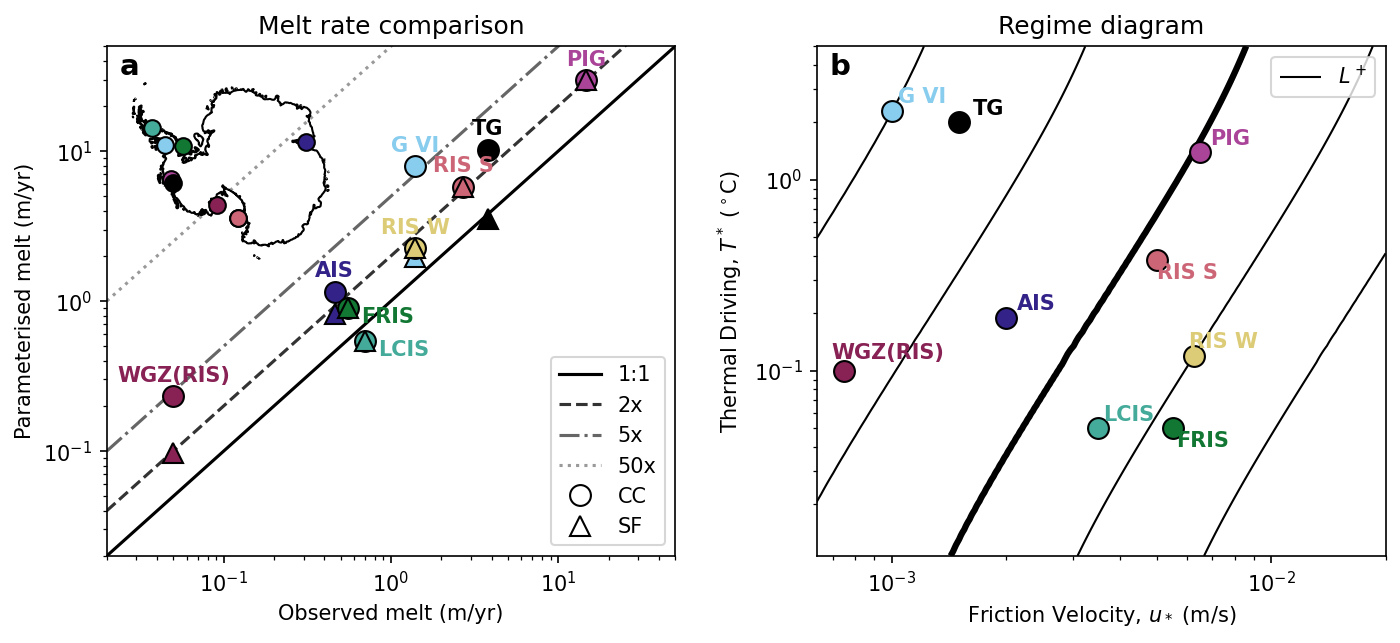

In [15]:
## Go from Thermal Driving to T_m


fig, axes = plt.subplots( figsize = (11,4.5),dpi = 150, ncols = 2)
plot_R22Lplus(axes[1])
#for name in Obs:

axes[0].plot([0.02,100],[0.02,100],'-k', label = '1:1')
axes[0].plot([0.02,100],[0.04,200],'--k', label = '2x',alpha = 0.8)
axes[0].plot([0.02,100],[0.1,500],'-.k', label = '5x',alpha = 0.6)
axes[0].plot([0.02,100],[0.02*50,100*50],':k', label = '50x',alpha = 0.4)

ax_inset = plt.axes([0.05,0.55,0.3,0.3],projection=ccrs.SouthPolarStereo())
ax_inset.set_extent([-180, 180, -90, -65], ccrs.PlateCarree())
ax_inset.coastlines()
ax_inset.axis('off')


for k, d in Obs.items():

    ustar_J10 = d['u']*np.sqrt(0.0097)
    ustar_isomip = d['u']*np.sqrt(0.0025)
    if k == 'G VI':
        ustar_isomip = 0.1e-2 #m/s from Middleton et al. 2022
    ThermalDriving = d['madiTstar']#d['T_m'] - Tfreeze(d['S_m'],d['depth'])
    #print(d['T_m'])
    T_b = Tfreeze(d['S_m'],d['depth'])+ThermalDriving #CT_freezing(d['S_m'],d['depth'],0)
    #print(Tfreeze(d['S_m'],d['depth']))
    #print(d['Tstar']+ Tfreeze(d['S_m'],d['depth']))
    #print('Thermal Driving',ThermalDriving)
    
    T,S,meltR22lim,GT,GS,Lplus = solve_three_eqn_python_isomipcoeffs(ustar_isomip, d['depth'], 
                                                            T_b, d['S_m'],
                                                            J10_Gamma = False, Rosevear_Gamma = False,R22lim = True)
    axes[0].plot( d['obsm'],meltR22lim, 'o', color = d['color'], markersize = 10, mec = 'k')
    print('T',T)
    print('S_m',d['S_m'],'S',S)
    print(k,'R22 const coeff mr = ',meltR22lim)
    T,S,meltR22strat,GT,GS,Lplus = solve_three_eqn_python_isomipcoeffs(ustar_isomip, d['depth'], 
                                                            T_b, d['S_m'],
                                                            J10_Gamma = False, Rosevear_Gamma = True)
    axes[0].plot( d['obsm'],meltR22strat, '^',color = d['color'], markersize = 10, mec = 'k')
    print(k,'R22 strat mr = ',meltR22strat, 'impliedLplus',Lplus)
    #cs = axes[1].plot( ustar_isomip,ThermalDriving, label = k,color='black',marker='o', markersize = 10,markerfacecolor = d['color'])
    cs = axes[1].plot( ustar_isomip,ThermalDriving, 'o',color = d['color'],markersize = 10, mec = 'k')
    if (k == 'LCIS' or k=='FRIS'):
        axes[0].text(d['obsm']*1.2,meltR22lim*0.8,k,ha = 'left',color = d['color'],fontweight = 'bold')        
    else:
        axes[0].text(d['obsm'],meltR22lim*1.25,k,ha = 'center',color = d['color'],fontweight = 'bold')
    if (k=='FRIS' or k=='RIS S'):
        axes[1].text(ustar_isomip*1.2,ThermalDriving*0.8,k,ha = 'center',color = d['color'],fontweight = 'bold')  
    elif (k =='WGZ(RIS)'):
        axes[1].text(ustar_isomip*1.3,ThermalDriving*1.15,k,ha = 'center',color = d['color'],fontweight = 'bold')        
    else:
        axes[1].text(ustar_isomip*1.2,ThermalDriving*1.1,k,ha = 'center',color = d['color'],fontweight = 'bold')

    ax_inset.plot(d['lon'],d['lat'],'o',color = d['color'],markersize = 8,mec = 'k',transform=ccrs.PlateCarree())
    
axes[0].plot( 0.0001,0.0001, 'o', color = 'w', markersize = 10, mec = 'k',label = 'CC')
axes[0].plot( 0.0001,0.0001, '^',color = 'w', markersize = 10, mec = 'k',label = 'SF')

axes[0].legend(ncol = 1,loc = 'lower right')

axes[0].set_xlabel('Observed melt (m/yr)')
axes[0].set_ylabel('Parameterised melt (m/yr)')
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_xlim(0.02,50)
axes[0].set_ylim(0.02,50)
axes[0].set_title('Melt rate comparison');

axes[1].set_yscale('log')
axes[1].set_xscale('log')
axes[1].set_title('Regime diagram')
axes[0].text(0.04,0.96,'a',horizontalalignment='center', fontweight='bold',
     verticalalignment='center',transform=axes[0].transAxes, fontsize = 14)
axes[1].text(0.04,0.96,'b',horizontalalignment='center', fontweight='bold',
     verticalalignment='center',transform=axes[1].transAxes, fontsize = 14)




fig.subplots_adjust(wspace = 0.25)

/Users/claireyung/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


T -2.195186753316115
S_m 34.59 S 33.11273749242784
AIS R22 const coeff mr =  1.1537565243246977
AIS R22 strat mr =  0.8163581890291463 impliedLplus 2954.8632053534875
T -2.25218531197882
S_m 34.51 S 34.10747673610506
FRIS R22 const coeff mr =  0.8715636533420849
FRIS R22 strat mr =  0.8715636533419324 impliedLplus 154553.89038601296
T -2.2521853119788213
S_m 34.54 S 34.107476736105085
LCIS R22 const coeff mr =  0.5546314157631682
LCIS R22 strat mr =  0.554631415761085 impliedLplus 39828.68850669032
T -1.5503530340073597
S_m 34.62 S 21.859094921594412
G VI R22 const coeff mr =  7.962814626935244
G VI R22 strat mr =  1.979928139631436 impliedLplus 99.0237440324307
T -2.223435984412255
S_m 34.5 S 33.605743270719984
RIS W R22 const coeff mr =  2.29007307291135
RIS W R22 strat mr =  2.290073072911389 impliedLplus 99392.81512985098
T -2.1209965654645444
S_m 34.3 S 31.817969816135154
RIS S R22 const coeff mr =  5.8033907247931165
RIS S R22 strat mr =  5.803390724801686 impliedLplus 16866.9087

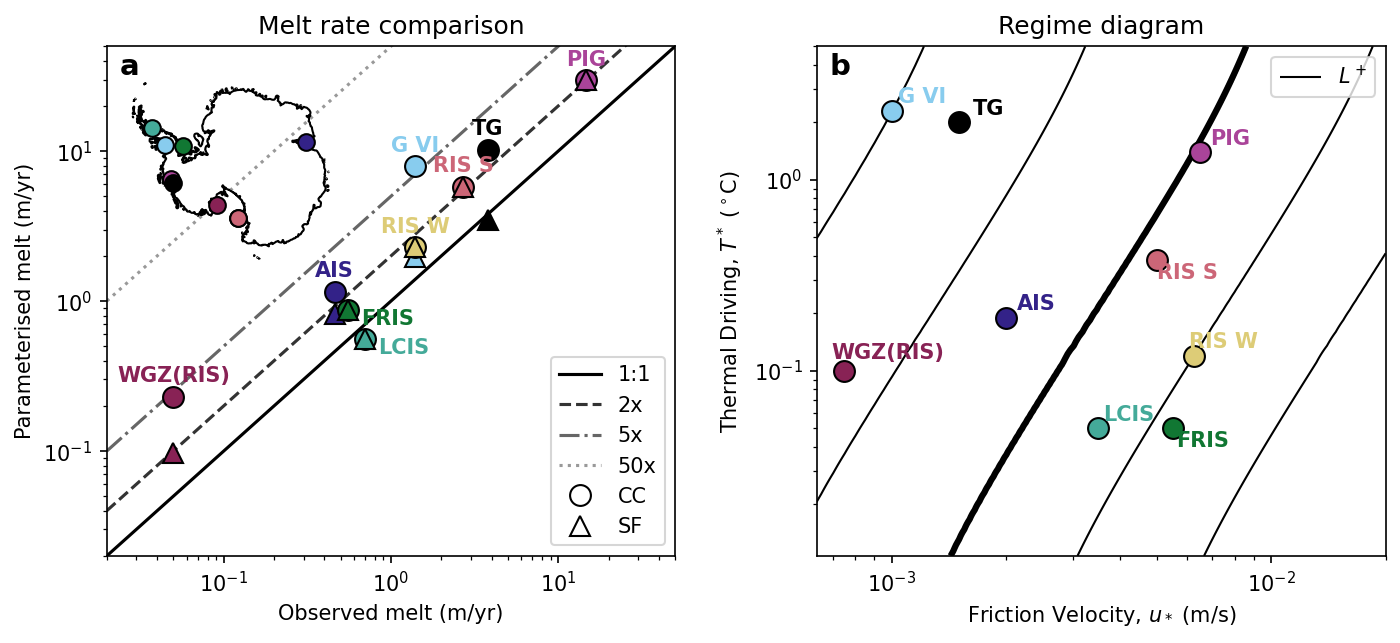

In [16]:
## Go from Thermal Driving to T_m assuming S=34.5 and p=500
fig, axes = plt.subplots( figsize = (11,4.5),dpi = 150, ncols = 2)
plot_R22Lplus(axes[1])
#for name in Obs:

axes[0].plot([0.02,100],[0.02,100],'-k', label = '1:1')
axes[0].plot([0.02,100],[0.04,200],'--k', label = '2x',alpha = 0.8)
axes[0].plot([0.02,100],[0.1,500],'-.k', label = '5x',alpha = 0.6)
axes[0].plot([0.02,100],[0.02*50,100*50],':k', label = '50x',alpha = 0.4)

ax_inset = plt.axes([0.05,0.55,0.3,0.3],projection=ccrs.SouthPolarStereo())
ax_inset.set_extent([-180, 180, -90, -65], ccrs.PlateCarree())
ax_inset.coastlines()
ax_inset.axis('off')


for k, d in Obs.items():

    ustar_J10 = d['u']*np.sqrt(0.0097)
    ustar_isomip = d['u']*np.sqrt(0.0025)
    if k == 'G VI':
        ustar_isomip = 0.1e-2 #m/s from Middleton et al. 2022
    ThermalDriving = d['madiTstar']#d['T_m'] - Tfreeze(d['S_m'],d['depth'])
    #print(d['T_m'])
    T_b = Tfreeze(34.5,500)+ThermalDriving #CT_freezing(d['S_m'],d['depth'],0)
    #print(Tfreeze(d['S_m'],d['depth']))
    #print(d['Tstar']+ Tfreeze(d['S_m'],d['depth']))
    #print('Thermal Driving',ThermalDriving)
    
    T,S,meltR22lim,GT,GS,Lplus = solve_three_eqn_python_isomipcoeffs(ustar_isomip, 500,#d['depth'], 
                                                            T_b, 34.5,#d['S_m'],
                                                            J10_Gamma = False, Rosevear_Gamma = False,R22lim = True)
    axes[0].plot( d['obsm'],meltR22lim, 'o', color = d['color'], markersize = 10, mec = 'k')
    print('T',T)
    print('S_m',d['S_m'],'S',S)
    print(k,'R22 const coeff mr = ',meltR22lim)
    T,S,meltR22strat,GT,GS,Lplus = solve_three_eqn_python_isomipcoeffs(ustar_isomip, 500,#d['depth'], 
                                                            T_b, 34.5,#d['S_m'],
                                                            J10_Gamma = False, Rosevear_Gamma = True)
    axes[0].plot( d['obsm'],meltR22strat, '^',color = d['color'], markersize = 10, mec = 'k')
    print(k,'R22 strat mr = ',meltR22strat, 'impliedLplus',Lplus)
    #cs = axes[1].plot( ustar_isomip,ThermalDriving, label = k,color='black',marker='o', markersize = 10,markerfacecolor = d['color'])
    cs = axes[1].plot( ustar_isomip,ThermalDriving, 'o',color = d['color'],markersize = 10, mec = 'k')
    if (k == 'LCIS' or k=='FRIS'):
        axes[0].text(d['obsm']*1.2,meltR22lim*0.8,k,ha = 'left',color = d['color'],fontweight = 'bold')        
    else:
        axes[0].text(d['obsm'],meltR22lim*1.25,k,ha = 'center',color = d['color'],fontweight = 'bold')
    if (k=='FRIS' or k=='RIS S'):
        axes[1].text(ustar_isomip*1.2,ThermalDriving*0.8,k,ha = 'center',color = d['color'],fontweight = 'bold')  
    elif (k =='WGZ(RIS)'):
        axes[1].text(ustar_isomip*1.3,ThermalDriving*1.15,k,ha = 'center',color = d['color'],fontweight = 'bold')        
    else:
        axes[1].text(ustar_isomip*1.2,ThermalDriving*1.1,k,ha = 'center',color = d['color'],fontweight = 'bold')

    ax_inset.plot(d['lon'],d['lat'],'o',color = d['color'],markersize = 8,mec = 'k',transform=ccrs.PlateCarree())
    
axes[0].plot( 0.0001,0.0001, 'o', color = 'w', markersize = 10, mec = 'k',label = 'CC')
axes[0].plot( 0.0001,0.0001, '^',color = 'w', markersize = 10, mec = 'k',label = 'SF')

axes[0].legend(ncol = 1,loc = 'lower right')

axes[0].set_xlabel('Observed melt (m/yr)')
axes[0].set_ylabel('Parameterised melt (m/yr)')
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_xlim(0.02,50)
axes[0].set_ylim(0.02,50)
axes[0].set_title('Melt rate comparison');

axes[1].set_yscale('log')
axes[1].set_xscale('log')
axes[1].set_title('Regime diagram')
axes[0].text(0.04,0.96,'a',horizontalalignment='center', fontweight='bold',
     verticalalignment='center',transform=axes[0].transAxes, fontsize = 14)
axes[1].text(0.04,0.96,'b',horizontalalignment='center', fontweight='bold',
     verticalalignment='center',transform=axes[1].transAxes, fontsize = 14)




fig.subplots_adjust(wspace = 0.25)

/Users/claireyung/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


T -2.188590823307106
S_m 34.59 S 32.99762527586573
AIS R22 const coeff mr =  1.9631755595339309
T -2.2503098805738655
S_m 34.51 S 34.07474669413378
FRIS R22 const coeff mr =  1.4798282467694115
T -2.2503098805738513
S_m 34.54 S 34.07474669413353
LCIS R22 const coeff mr =  0.941708884307351
T -1.4993056111428609
S_m 34.62 S 20.968214941411183
G VI R22 const coeff mr =  27.826410492420457
T -2.219173233192894
S_m 34.5 S 33.53134970668227
RIS W R22 const coeff mr =  3.892508391918533
T -2.1083473447036036
S_m 34.3 S 31.5972155271135
RIS S R22 const coeff mr =  9.90306304795815
T -1.7458249523536962
S_m 33.85 S 25.27047220512559
PIG R22 const coeff mr =  51.181503836126694
T -2.228012726403699
S_m 34.74 S 33.685616603903995
WGZ(RIS) R22 const coeff mr =  0.39091220803698873
T -1.573279397964262
S_m 34.38 S 22.259205985414695
TG R22 const coeff mr =  17.783807197779822


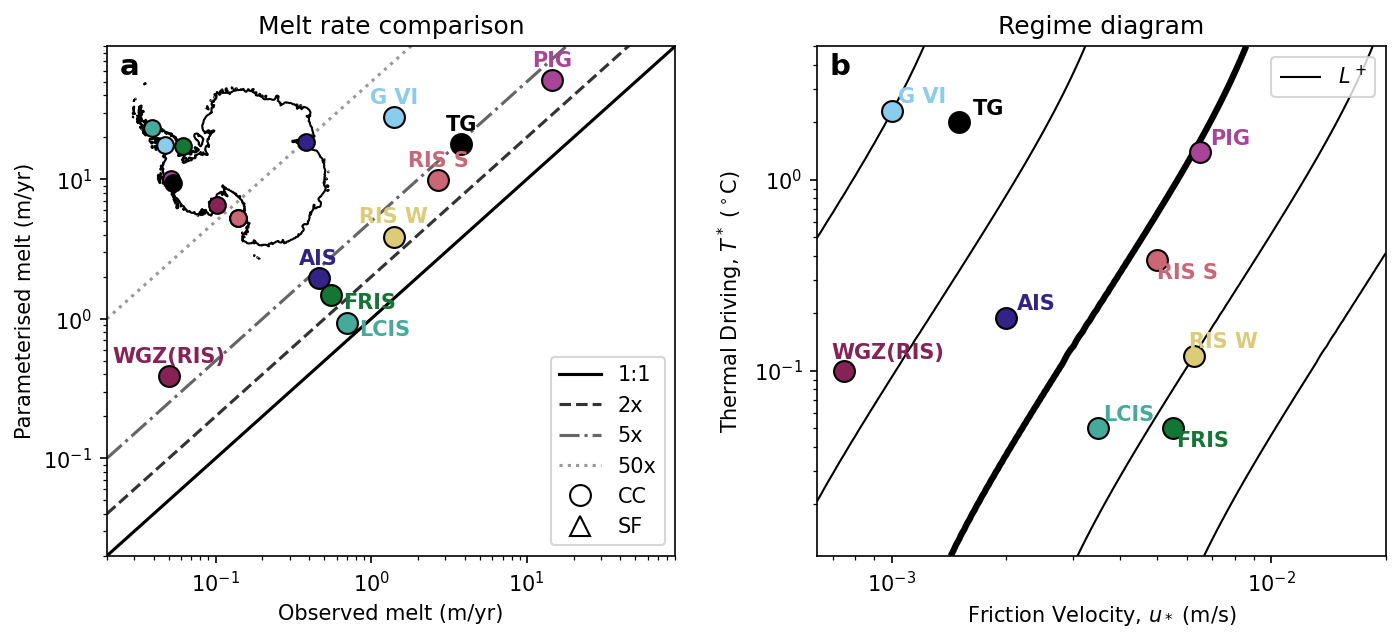

In [20]:
## Go from Thermal Driving to T_m assuming S=34.5 and p=500, J10 version


fig, axes = plt.subplots( figsize = (11,4.5),dpi = 150, ncols = 2)
plot_R22Lplus(axes[1])
#for name in Obs:

axes[0].plot([0.02,100],[0.02,100],'-k', label = '1:1')
axes[0].plot([0.02,100],[0.04,200],'--k', label = '2x',alpha = 0.8)
axes[0].plot([0.02,100],[0.1,500],'-.k', label = '5x',alpha = 0.6)
axes[0].plot([0.02,100],[0.02*50,100*50],':k', label = '50x',alpha = 0.4)

ax_inset = plt.axes([0.05,0.55,0.3,0.3],projection=ccrs.SouthPolarStereo())
ax_inset.set_extent([-180, 180, -90, -65], ccrs.PlateCarree())
ax_inset.coastlines()
ax_inset.axis('off')


for k, d in Obs.items():

    ustar_J10 = d['u']*np.sqrt(0.0097)
    ustar_isomip = d['u']*np.sqrt(0.0025)
    if k == 'G VI':
        ustar_isomip = 0.1e-2 #m/s from Middleton et al. 2022
    ThermalDriving = d['madiTstar']#d['T_m'] - Tfreeze(d['S_m'],d['depth'])
    #print(d['T_m'])
    T_b = Tfreeze(34.5,500)+ThermalDriving #CT_freezing(d['S_m'],d['depth'],0)
    #print(Tfreeze(d['S_m'],d['depth']))
    #print(d['Tstar']+ Tfreeze(d['S_m'],d['depth']))
    #print('Thermal Driving',ThermalDriving)
    
    T,S,meltR22lim,GT,GS,Lplus = solve_three_eqn_python_isomipcoeffs(ustar_J10, 500,#d['depth'], 
                                                            T_b, 34.5,#d['S_m'],
                                                            J10_Gamma = True, Rosevear_Gamma = False,R22lim = False)
    axes[0].plot( d['obsm'],meltR22lim, 'o', color = d['color'], markersize = 10, mec = 'k')
    print('T',T)
    print('S_m',d['S_m'],'S',S)
    print(k,'R22 const coeff mr = ',meltR22lim)
    #T,S,meltR22strat,GT,GS,Lplus = solve_three_eqn_python_isomipcoeffs(ustar_isomip, 500,#d['depth'], 
    #                                                        T_b, 34.5,#d['S_m'],
    #                                                        J10_Gamma = False, Rosevear_Gamma = True)
    #axes[0].plot( d['obsm'],meltR22strat, '^',color = d['color'], markersize = 10, mec = 'k')
    #print(k,'R22 strat mr = ',meltR22strat, 'impliedLplus',Lplus)
    #cs = axes[1].plot( ustar_isomip,ThermalDriving, label = k,color='black',marker='o', markersize = 10,markerfacecolor = d['color'])
    cs = axes[1].plot( ustar_isomip,ThermalDriving, 'o',color = d['color'],markersize = 10, mec = 'k')
    if (k == 'LCIS' or k=='FRIS'):
        axes[0].text(d['obsm']*1.2,meltR22lim*0.8,k,ha = 'left',color = d['color'],fontweight = 'bold')        
    else:
        axes[0].text(d['obsm'],meltR22lim*1.25,k,ha = 'center',color = d['color'],fontweight = 'bold')
    if (k=='FRIS' or k=='RIS S'):
        axes[1].text(ustar_isomip*1.2,ThermalDriving*0.8,k,ha = 'center',color = d['color'],fontweight = 'bold')  
    elif (k =='WGZ(RIS)'):
        axes[1].text(ustar_isomip*1.3,ThermalDriving*1.15,k,ha = 'center',color = d['color'],fontweight = 'bold')        
    else:
        axes[1].text(ustar_isomip*1.2,ThermalDriving*1.1,k,ha = 'center',color = d['color'],fontweight = 'bold')

    ax_inset.plot(d['lon'],d['lat'],'o',color = d['color'],markersize = 8,mec = 'k',transform=ccrs.PlateCarree())
    
axes[0].plot( 0.0001,0.0001, 'o', color = 'w', markersize = 10, mec = 'k',label = 'CC')
axes[0].plot( 0.0001,0.0001, '^',color = 'w', markersize = 10, mec = 'k',label = 'SF')

axes[0].legend(ncol = 1,loc = 'lower right')

axes[0].set_xlabel('Observed melt (m/yr)')
axes[0].set_ylabel('Parameterised melt (m/yr)')
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_xlim(0.02,90)
axes[0].set_ylim(0.02,90)
axes[0].set_title('Melt rate comparison');

axes[1].set_yscale('log')
axes[1].set_xscale('log')
axes[1].set_title('Regime diagram')
axes[0].text(0.04,0.96,'a',horizontalalignment='center', fontweight='bold',
     verticalalignment='center',transform=axes[0].transAxes, fontsize = 14)
axes[1].text(0.04,0.96,'b',horizontalalignment='center', fontweight='bold',
     verticalalignment='center',transform=axes[1].transAxes, fontsize = 14)




fig.subplots_adjust(wspace = 0.25)